##### Copyright 2020 Google

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# QAOA example problems

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/experiments/qaoa/example_problems"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/ReCirq/blob/master/docs/qaoa/example_problems.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/ReCirq/blob/master/docs/qaoa/example_problems.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/ReCirq/docs/qaoa/example_problems.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

The shallowest depth version of the Quantum Approximate Optimization Algorithm (QAOA) consists of the application of two unitary operators: the problem unitary and the driver unitary. The first of these depends on the parameter $\gamma$ and applies a phase to pairs of bits according to the problem-specific cost operator $C$:

$$
    U_C \! \left(\gamma \right) = e^{-i \gamma C } = \prod_{j < k} e^{-i \gamma w_{jk} Z_j Z_k}
$$

whereas the driver unitary depends on the parameter $\beta$, is problem-independent, and serves to drive transitions between bitstrings within the superposition state:

$$
    \newcommand{\gammavector}{\boldsymbol{\gamma}}
    \newcommand{\betavector}{\boldsymbol{\beta}}
    U_B \! \left(\beta \right) = e^{-i \beta B} = \prod_j e^{- i \beta X_j},
    \quad \qquad
    B = \sum_j X_j
$$

where $X_j$ is the Pauli $X$ operator on qubit $j$. These operators can be implemented by sequentially evolving under each term of the product; specifically the problem unitary is applied with a sequence of two-body interactions while the driver unitary is a single qubit rotation on each qubit. For higher-depth versions of the algorithm the two unitaries are sequentially re-applied each with their own $\beta$ or $\gamma$. The number of applications of the pair of unitaries is represented by the hyperparameter $p$ with parameters  $\gammavector = (\gamma_1, \dots, \gamma_p)$ and $\betavector = (\beta_1, \dots, \beta_p)$. For $n$ qubits, we prepare the parameterized state

$$
    \newcommand{\bra}[1]{\langle #1|}
    \newcommand{\ket}[1]{|#1\rangle}
    | \gammavector , \betavector \rangle = U_B(\beta_p)  U_C(\gamma_p ) \cdots U_B(\beta_1) U_C(\gamma_1 ) \ket{+}^{\otimes n},
$$		
where $\ket{+}^{\otimes n}$ is the symmetric superposition of computational basis states.

<img src="./images/qaoa_circuit.png" alt="QAOA circuit"/>

The optimization problems we study in this work are defined through a cost function with a corresponding quantum operator C given by

$$
    C  =  \sum_{j < k}  w_{jk}  Z_j  Z_k
$$

where $Z_j$ dnotes the Pauli $Z$ operator on qubit $j$, and the $w_{jk}$ correspond to scalar weights with values $\{0, \pm1\}$. Because these clauses act on at most two qubits, we are able to associate a graph with a given problem instance with weighted edges given by the $w_{jk}$ adjacency matrix.

## Setup

Install the ReCirq package:

In [2]:
try:
    import recirq
except ImportError:
    !pip install git+https://github.com/quantumlib/ReCirq

  Cloning https://github.com/quantumlib/ReCirq to /tmpfs/tmp/pip-req-build-gxme5oae
  Running command git clone --filter=blob:none --quiet https://github.com/quantumlib/ReCirq /tmpfs/tmp/pip-req-build-gxme5oae


  Resolved https://github.com/quantumlib/ReCirq to commit 07da5b164e0335830e74c582760718b2d57ba04a


  Preparing metadata (setup.py) ... -

 done


  Using cached cirq_core-1.4.1-py3-none-any.whl.metadata (1.8 kB)


  Using cached cirq_google-1.4.1-py3-none-any.whl.metadata (2.0 kB)


  Using cached sphinx-8.1.3-py3-none-any.whl.metadata (6.4 kB)


  Using cached black-24.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (79 kB)


  Using cached Py_BOBYQA-1.5.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached pytket_cirq-0.39.0-py3-none-any.whl.metadata (4.3 kB)


  Using cached openfermion-1.6.1-py3-none-any.whl.metadata (10 kB)
  Using cached fqe-0.3.0-cp310-cp310-linux_x86_64.whl


  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)


  Using cached ipie-0.7.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached openfermionpyscf-0.5-py3-none-any.whl.metadata (6.9 kB)


  Using cached pfapack-1.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.0 kB)


  Using cached pyscf-2.7.0-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)


  Using cached qsim-0.1.0.dev0-py3-none-any.whl.metadata (1.8 kB)
  Using cached qsimcirq-0.21.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)


  Using cached duet-0.2.9-py3-none-any.whl.metadata (2.3 kB)


  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl.metadata (10 kB)


  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)


  Using cached google_api_core-2.24.0-py3-none-any.whl.metadata (3.0 kB)


  Using cached proto_plus-1.25.0-py3-none-any.whl.metadata (2.2 kB)


  Using cached pytest-8.3.4-py3-none-any.whl.metadata (7.5 kB)


  Using cached numba-0.60.0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.7 kB)


  Using cached plum_dispatch-2.5.4-py3-none-any.whl.metadata (7.5 kB)


  Using cached deprecation-2.1.0-py2.py3-none-any.whl.metadata (4.6 kB)


  Using cached PubChemPy-1.0.4-py3-none-any.whl


  Using cached pytket-1.37.0-cp310-cp310-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (4.4 kB)


  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)


  Using cached mypy_extensions-1.0.0-py3-none-any.whl.metadata (1.1 kB)


  Using cached pathspec-0.12.1-py3-none-any.whl.metadata (21 kB)


  Using cached pyasn1_modules-0.2.7-py2.py3-none-any.whl.metadata (1.8 kB)


  Using cached Cython-3.0.11-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.2 kB)


  Using cached pyasn1-0.4.8-py2.py3-none-any.whl.metadata (1.5 kB)


  Using cached sphinxcontrib_applehelp-2.0.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached sphinxcontrib_devhelp-2.0.0-py3-none-any.whl.metadata (2.3 kB)


  Using cached sphinxcontrib_htmlhelp-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached sphinxcontrib_jsmath-1.0.1-py2.py3-none-any.whl.metadata (1.4 kB)


  Using cached sphinxcontrib_qthelp-2.0.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached sphinxcontrib_serializinghtml-2.0.0-py3-none-any.whl.metadata (2.4 kB)


  Using cached docutils-0.21.2-py3-none-any.whl.metadata (2.8 kB)
  Using cached snowballstemmer-2.2.0-py2.py3-none-any.whl.metadata (6.5 kB)


  Using cached alabaster-1.0.0-py3-none-any.whl.metadata (2.8 kB)
  Using cached imagesize-1.4.1-py2.py3-none-any.whl.metadata (1.5 kB)


  Using cached googleapis_common_protos-1.66.0-py2.py3-none-any.whl.metadata (1.5 kB)


  Using cached google_auth-2.37.0-py2.py3-none-any.whl.metadata (4.8 kB)


  Using cached grpcio_status-1.68.1-py3-none-any.whl.metadata (1.1 kB)


  Using cached lark-1.2.2-py3-none-any.whl.metadata (1.8 kB)


  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
  Using cached qwasm-1.0.1-py3-none-any.whl.metadata (299 bytes)


  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)


  Using cached llvmlite-0.43.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.8 kB)


  Using cached beartype-0.19.0-py3-none-any.whl.metadata (32 kB)
  Using cached iniconfig-2.0.0-py3-none-any.whl.metadata (2.6 kB)


  Using cached pluggy-1.5.0-py3-none-any.whl.metadata (4.8 kB)


  Using cached rsa-4.9-py3-none-any.whl.metadata (4.2 kB)


INFO: pip is looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
  Using cached grpcio_status-1.68.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached grpcio_status-1.67.1-py3-none-any.whl.metadata (1.1 kB)
  Using cached grpcio_status-1.67.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached grpcio_status-1.66.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached grpcio_status-1.66.1-py3-none-any.whl.metadata (1.1 kB)
  Using cached grpcio_status-1.66.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached grpcio_status-1.65.5-py3-none-any.whl.metadata (1.1 kB)
INFO: pip is still looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
  Using cached grpcio_status-1.65.4-py3-none-any.whl.metadata (1.1 kB)
  Using cached grpcio_status-1.65.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached grpcio_status-1.65.1-py3-none-any.whl.me

  Using cached grpcio_status-1.62.3-py3-none-any.whl.metadata (1.3 kB)


  Using cached protobuf-4.25.5-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)


Using cached cirq_core-1.4.1-py3-none-any.whl (1.9 MB)
Using cached cirq_google-1.4.1-py3-none-any.whl (532 kB)
Using cached ipie-0.7.1-py3-none-any.whl (528 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)


Using cached openfermion-1.6.1-py3-none-any.whl (1.2 MB)
Using cached pyscf-2.7.0-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (48.7 MB)


Using cached pytket_cirq-0.39.0-py3-none-any.whl (17 kB)
Using cached qsimcirq-0.21.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
Using cached black-24.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (1.8 MB)
Using cached filelock-3.16.1-py3-none-any.whl (16 kB)
Using cached pyasn1_modules-0.2.7-py2.py3-none-any.whl (131 kB)
Using cached sphinx-8.1.3-py3-none-any.whl (3.5 MB)
Using cached openfermionpyscf-0.5-py3-none-any.whl (16 kB)
Using cached pfapack-1.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.4 MB)
Using cached Py_BOBYQA-1.5.0-py3-none-any.whl (57 kB)
Using cached qsim-0.1.0.dev0-py3-none-any.whl (4.5 kB)
Using cached alabaster-1.0.0-py3-none-any.whl (13 kB)
Using cached docutils-0.21.2-py3-none-any.whl (587 kB)
Using cached duet-0.2.9-py3-none-any.whl (29 kB)
Using cached google_api_core-2.24.0-py3-none-any.whl (158 kB)
Using cached imagesize-1.4.1-py2.py3-none-any.whl (8.8 kB)
Using cached myp

Using cached pathspec-0.12.1-py3-none-any.whl (31 kB)
Using cached proto_plus-1.25.0-py3-none-any.whl (50 kB)
Using cached pytket-1.37.0-cp310-cp310-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (8.3 MB)
Using cached snowballstemmer-2.2.0-py2.py3-none-any.whl (93 kB)
Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl (29 kB)
Using cached sphinxcontrib_applehelp-2.0.0-py3-none-any.whl (119 kB)
Using cached sphinxcontrib_devhelp-2.0.0-py3-none-any.whl (82 kB)
Using cached sphinxcontrib_htmlhelp-2.1.0-py3-none-any.whl (98 kB)
Using cached sphinxcontrib_jsmath-1.0.1-py2.py3-none-any.whl (5.1 kB)
Using cached sphinxcontrib_qthelp-2.0.0-py3-none-any.whl (88 kB)
Using cached sphinxcontrib_serializinghtml-2.0.0-py3-none-any.whl (92 kB)
Using cached sympy-1.13.3-py3-none-any.whl (6.2 MB)
Using cached Cython-3.0.11-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
Using cached deprecation-2.1.0-py2.py3-none-any.whl (11 kB)
Using cached numba-0.60.0-cp310-cp310-manylinux

Using cached googleapis_common_protos-1.66.0-py2.py3-none-any.whl (221 kB)
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)
Using cached grpcio_status-1.62.3-py3-none-any.whl (14 kB)
Using cached protobuf-4.25.5-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
Using cached lark-1.2.2-py3-none-any.whl (111 kB)
Using cached llvmlite-0.43.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (43.9 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)


Using cached pluggy-1.5.0-py3-none-any.whl (20 kB)
Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
Using cached qwasm-1.0.1-py3-none-any.whl (15 kB)
Using cached iniconfig-2.0.0-py3-none-any.whl (5.9 kB)
Using cached rsa-4.9-py3-none-any.whl (34 kB)


 \

 |

 /

 -

 done
  Created wheel for recirq: filename=recirq-0.1.dev0-py3-none-any.whl size=1282054 sha256=ecf3872c2424ae2e4110d8203075d4b8e1842caf4646da335f953dd61bc717ea
  Stored in directory: /tmpfs/tmp/pip-ephem-wheel-cache-v08oogn0/wheels/ce/5f/69/39665718f7e827ef4b0d4478917e63f4b3e7035a2c27c08b20


Successfully built recirq


  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3


    Uninstalling protobuf-3.20.3:


      Successfully uninstalled protobuf-3.20.3


  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2


    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.


Now import Cirq, ReCirq and the module dependencies:

In [3]:
import networkx as nx
import numpy as np
import scipy.optimize
import cirq
import recirq

%matplotlib inline
from matplotlib import pyplot as plt

In [4]:
# theme colors
QBLUE = '#1967d2'
QRED = '#ea4335ff'
QGOLD = '#fbbc05ff'

## Hardware grid

First, we study problem graphs which match the connectivity of our hardware, which we term "Hardware Grid problems". Despite results showing that problems on such graphs are efficient to solve on average, we study these problems as they do not require routing. This family of problems is composed of random instances generated by sampling $w_{ij}$ to be $\pm 1$ for edges in the device topology or a subgraph thereof.

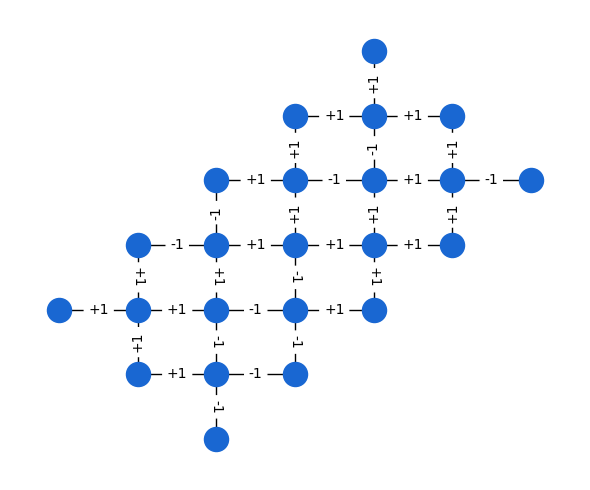

In [5]:
from recirq.qaoa.problems import get_all_hardware_grid_problems
import cirq.contrib.routing as ccr

hg_problems = get_all_hardware_grid_problems(
    device_graph=ccr.gridqubits_to_graph_device(recirq.get_device_obj_by_name('Sycamore23').metadata.qubit_set),
    central_qubit=cirq.GridQubit(6,3),
    n_instances=10,
    rs=np.random.RandomState(5)
)   

instance_i = 0
n_qubits = 23
problem = hg_problems[n_qubits, instance_i]

fig, ax = plt.subplots(figsize=(6,5))
pos = {i: coord for i, coord in enumerate(problem.coordinates)}
nx.draw_networkx(problem.graph, pos=pos, with_labels=False, node_color=QBLUE)
if True:  # toggle edge labels
    edge_labels = {(i1, i2): f"{weight:+d}"
                   for i1, i2, weight in problem.graph.edges.data('weight')}
    nx.draw_networkx_edge_labels(problem.graph, pos=pos, edge_labels=edge_labels)
ax.axis('off')
fig.tight_layout()

## Sherrington-Kirkpatrick model

Next, we study instances of the Sherrington-Kirkpatrick (SK) model, defined on the complete graph with $w_{ij}$ randomly chosen to be $\pm 1$. This is a canonical example of a frustrated spin glass and is most penalized by routing, which can be performed optimally using the linear swap networks at the cost of a linear increase in circuit depth. 

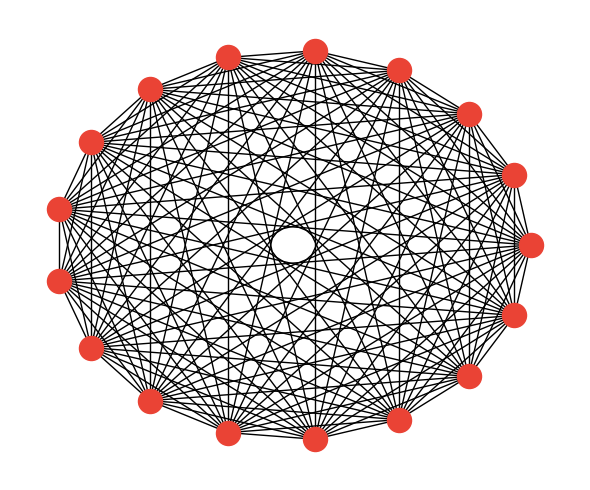

In [6]:
from recirq.qaoa.problems import get_all_sk_problems

n_qubits = 17
all_sk_problems = get_all_sk_problems(max_n_qubits=17, n_instances=10, rs=np.random.RandomState(5))
sk_problem = all_sk_problems[n_qubits, instance_i]

fig, ax = plt.subplots(figsize=(6,5))
pos = nx.circular_layout(sk_problem.graph)
nx.draw_networkx(sk_problem.graph, pos=pos, with_labels=False, node_color=QRED)
if False:  # toggle edge labels
    edge_labels = {(i1, i2): f"{weight:+d}"
                   for i1, i2, weight in sk_problem.graph.edges.data('weight')}
    nx.draw_networkx_edge_labels(sk_problem.graph, pos=pos, edge_labels=edge_labels)
ax.axis('off')
fig.tight_layout()

## 3-regular MaxCut

Finally, we study instances of the MaxCut problem on 3-regular graphs. This is a prototypical discrete optimization problem with a low, fixed node degree but a high dimension which cannot be trivially mapped to a planar architecture. It more closely matches problems of industrial interest. For these problems, we use an automated routing algorithm to heuristically insert SWAP operations.

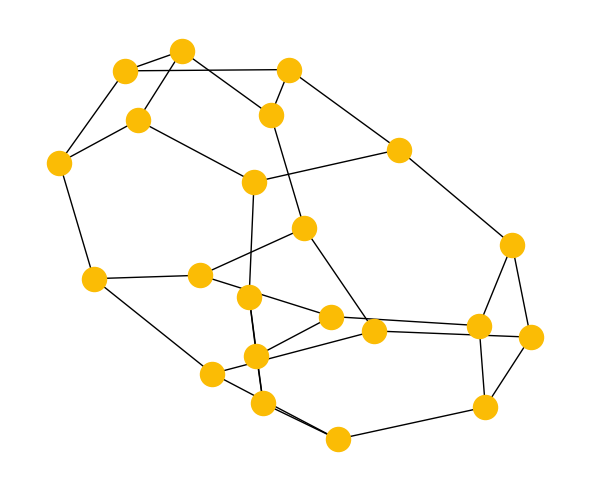

In [7]:
from recirq.qaoa.problems import get_all_3_regular_problems

n_qubits = 22
instance_i = 0
threereg_problems = get_all_3_regular_problems(max_n_qubits=22, n_instances=10, rs=np.random.RandomState(5))
threereg_problem = threereg_problems[n_qubits, instance_i]

fig, ax = plt.subplots(figsize=(6,5))
pos = nx.spring_layout(threereg_problem.graph, seed=11)
nx.draw_networkx(threereg_problem.graph, pos=pos, with_labels=False, node_color=QGOLD)
if False:  # toggle edge labels
    edge_labels = {(i1, i2): f"{weight:+d}"
                   for i1, i2, weight in threereg_problem.graph.edges.data('weight')}
    nx.draw_networkx_edge_labels(threereg_problem.graph, pos=pos, edge_labels=edge_labels)
ax.axis('off')
fig.tight_layout()